# Final Project, STAT-S610 - Statistical computing
### Fault Kinematics Along the San Andreas Fault from GPS Data Using Metropolis MCMC
Nicolás Castro-Perdomo

### Main Goal: 
- Implement a random walk Metropolis sampling algorithm to estimate fault kinematic parameters $(a, v_0, D_L, x_0)$ in an elastic dislocation model commonly used in geodetic/geophysical studies (e.g., Weertman and Weertman, 1964; Savage and Burford, 1973). 

- The model describes the theoretical horizontal velocity profile across a vertical fault as a function of the distance $x$ from the fault:

$$
v(x) = a + \frac{v_0}{\pi} tan^{-1} \Big( \frac{x-x_0}{D_L} \Big)
$$

where $a$ is a constant vertical shift applied to the velocity profile, $v_0$ is the fault slip rate, $D_L$ is the fault locking depth, $x_0$ is the fault location and $x$ is the distance perpendicular to the fault.

## Part 1: Model parameters

- The parameter domain is defined as follows: 
    - x $\in$ [−150, 150] km
    - a $\in$ [-5, 5] mm/yr
    - $v_0$ $\in$ [0, 50] mm/yr
    - $D_L$ $\in$ [0, 50] km
    - $x_0$ $\in$ [−25, 25] km
    
- A Gaussian error model will be used, so that at any given location $x_j$, fault-parallel velocities satisfy:

$$
v_j = v(x_j) + \eta_j
$$

where $\eta_j$ $\sim\mathcal{N}$(0, 1) and all $\eta_j$ are independently identically distributed

In [16]:
"""
Final Project - Statistical Computing
Slip Rate and Locking Depth Estimation Along the San Andreas Fault from GPS Data Using Bayesian Inference and MCMC
 - fault slip rate is v0 ∈ [0, 100] (mm/year)
 - locking depth is D ∈ [0, 50] (km) 
 - fault location is x0 ∈ [−10, 10] (km)
Nicolas Castro-Perdomo, November 2022
"""
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%matplotlib notebook 
#%%%%%%%%%%%%%%%%%%%%%%%% Import required libraries %%%%%%%%%%%%%%%%%%%%%%%%
from ipywidgets import interact
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
from matplotlib import interactive
import seaborn as sb
import math
import time
import corner
from scipy import stats
from scipy.interpolate import griddata
from matplotlib.colors import ListedColormap
from matplotlib import cm
interactive(True)
sb.set(style='white')
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

### Read and Plot Input Data

In [17]:
#%%%%%%%%%%%%%%%%%%%%%%%%%% Load Input Data %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
data = np.loadtxt('input_data/input_gps_california.csv',dtype=float, delimiter=',')
x_data = data[:,0]
v_data = data[:,1]
x = np.linspace(-150, 150,1000)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%  Functions  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Elastic halfspace model (Savage & Burford, 1973)
def elastic_model(x, a, v_0, D, x_0):
    return a - v_0*np.arctan((x-x_0)/D)/np.pi

def update(a = -1, v_0 = 37, D = 20, x_0 = -2):
    line.set_ydata(elastic_model(x,a,v_0,D,x_0))
    fig.canvas.draw_idle()
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

<IPython.core.display.Javascript object>


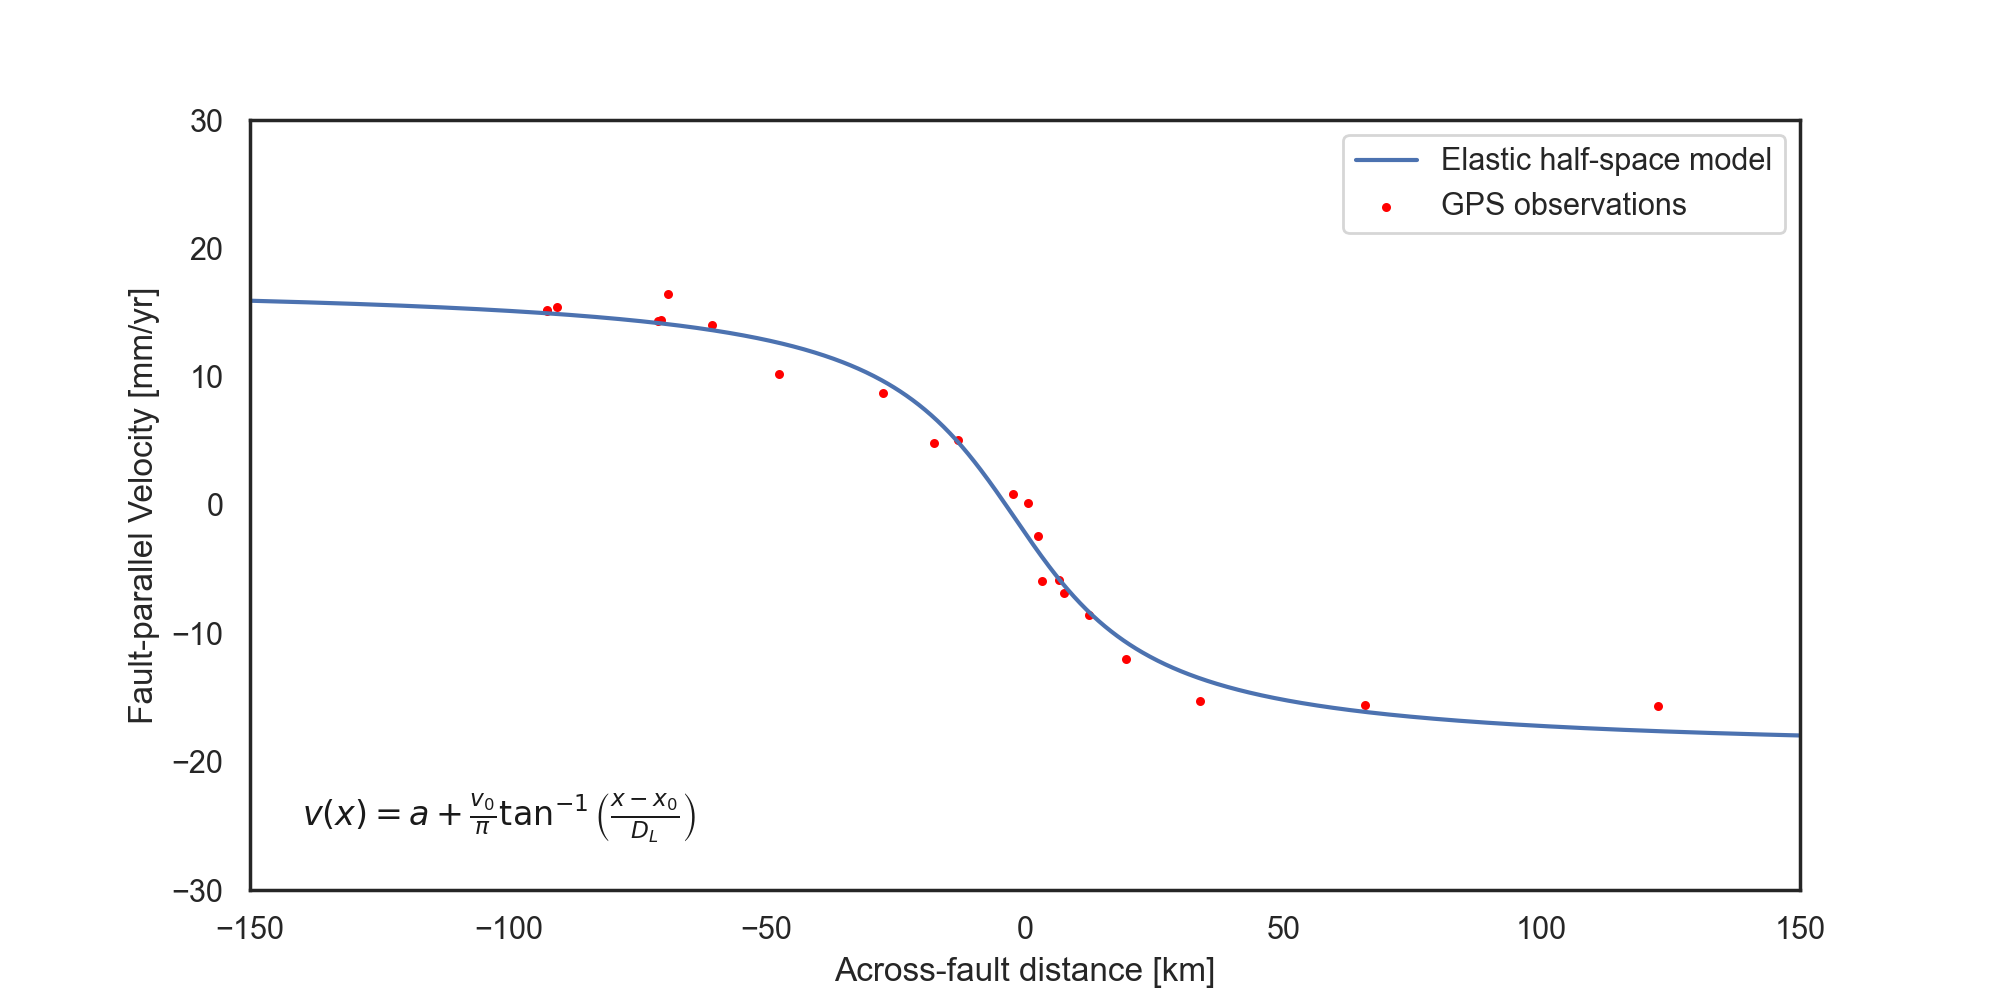

interactive(children=(FloatSlider(value=-1.0, description='a', max=5.0, min=-5.0), FloatSlider(value=37.0, des…

In [18]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(x, elastic_model(x, a = 1, v_0 = 1, D = 1, x_0 = 1), label='Elastic half-space model')
plt.scatter(x_data, v_data, s=5, color='red', label='GPS observations')
plt.xlabel('Across-fault distance [km]') ; plt.ylabel('Fault-parallel Velocity [mm/yr]')  
plt.legend()
interact(update, a = (-5,5,0.1), v_0 = (0,50,0.1), D = (0.1,50,0.1), x_0 = (-25,25,0.1))
plt.text(-140, -25, r'$v(x) = a + \frac{v_0}{\pi} \tan^{-1} \left( \frac{x-x_0}{D_L} \right)$', color="k", fontsize=12)
ax.set(xlim=(min(x), max(x)), ylim=(-30, 30)) ;

## Part 2: Metropolis MCMC Implementation

In [4]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%  Functions  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def model(thetam,x):
    # Elastic half-space model (Savage & Burford, 1973)
    [a,v_0,D,x_0] = thetam
    return a - v_0*np.arctan((x-x_0)/D)/np.pi 

def log_target_distribution(y,x,thetam,sigma):
    # log likelihood function
    [a, v_0,D,x_0] = thetam
    if v_0 < 0 or v_0 > 50 or abs(x_0)>25 or D <0 or D>50 or abs(a)>5:
        factor = 0
    else:
        factor = 1
    y_m = model(thetam,x)
    return np.sum(-(y-y_m)*(y-y_m)/(2*sigma*sigma))*factor
    
def rmse(x,y,thetam):
    # Compute the Root Mean Square Error (RMSE)
    Ny = len(y)
    sigma = 1 # np.sqrt(np.var(y))
    SUM_y_ym = np.sum((y - model(thetam,x))**2/sigma)
    return np.sqrt(SUM_y_ym/Ny)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [5]:
#%%%%%%%%%%%%%%%%%%%%%%  Initialise Markov chain  %%%%%%%%%%%%%%%%%%%%%%%%%%
samples = [] # Array that will be filled with accepted proposed samples
theta0 = [0,40,40,0] # Initial set of model parameters
theta = theta0       # Initial set of model parameters
acc_step = 0         # Initialise number of accepted steps
N = 100000           # Number of steps
s_rw = 0.3           # random walk step size 
rmse_mcmc = []       # Array that will be filled with RMSE(accepted_model_parameters)
rng = default_rng()  # default random number generator

In [6]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%  MCMC routine  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
start_time = time.time()
for step in range(N):
    samples.append(theta)
    # Metropolis random walk
    theta1 = theta + s_rw*rng.multivariate_normal(np.zeros(4), np.identity(4))
    # Acceptance probability (alpha): 
    alpha = min(1, np.exp(log_target_distribution(v_data, x_data, theta1,1)-log_target_distribution(v_data, x_data, theta,1)))
    #print(alpha)
    p = np.random.uniform(0,1)
    # Acceptance criteria
    if alpha > p :
        theta = theta1
        acc_step += 1
    rmse_mcmc.append(rmse(x_data,v_data,theta)) # Estimate error for current model parameters
executionTime = (time.time() - start_time)
#%%%%%%%%%%%%% Print execution time and MCMC acceptance rate  %%%%%%%%%%%%%%%
print("MCMC Execution Time (seconds):", executionTime)
print("Acceptance rate:",acc_step/N)

MCMC Execution Time (seconds): 13.884345293045044
Acceptance rate: 0.53522


In [7]:
#%%%%%%%%%%%%%%%%%%%%%%%%%  Plot MCMC results  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%
samples = np.array(samples)
rmse_mcmc1 = rmse_mcmc
# Here, let's define the Burn-in period as the number of iterations before the 
# MCMC algorithm performs a Metropolis random walk step that leads to a RMSE < 1.5. 
# Parameter estimates before that point are discarted.
burn_in_index = np.argmax(np.array(rmse_mcmc1) < 1.5)
print('Proposed samples discarded in Burn-in period:', burn_in_index)

Proposed samples discarded in Burn-in period: 519


<IPython.core.display.Javascript object>


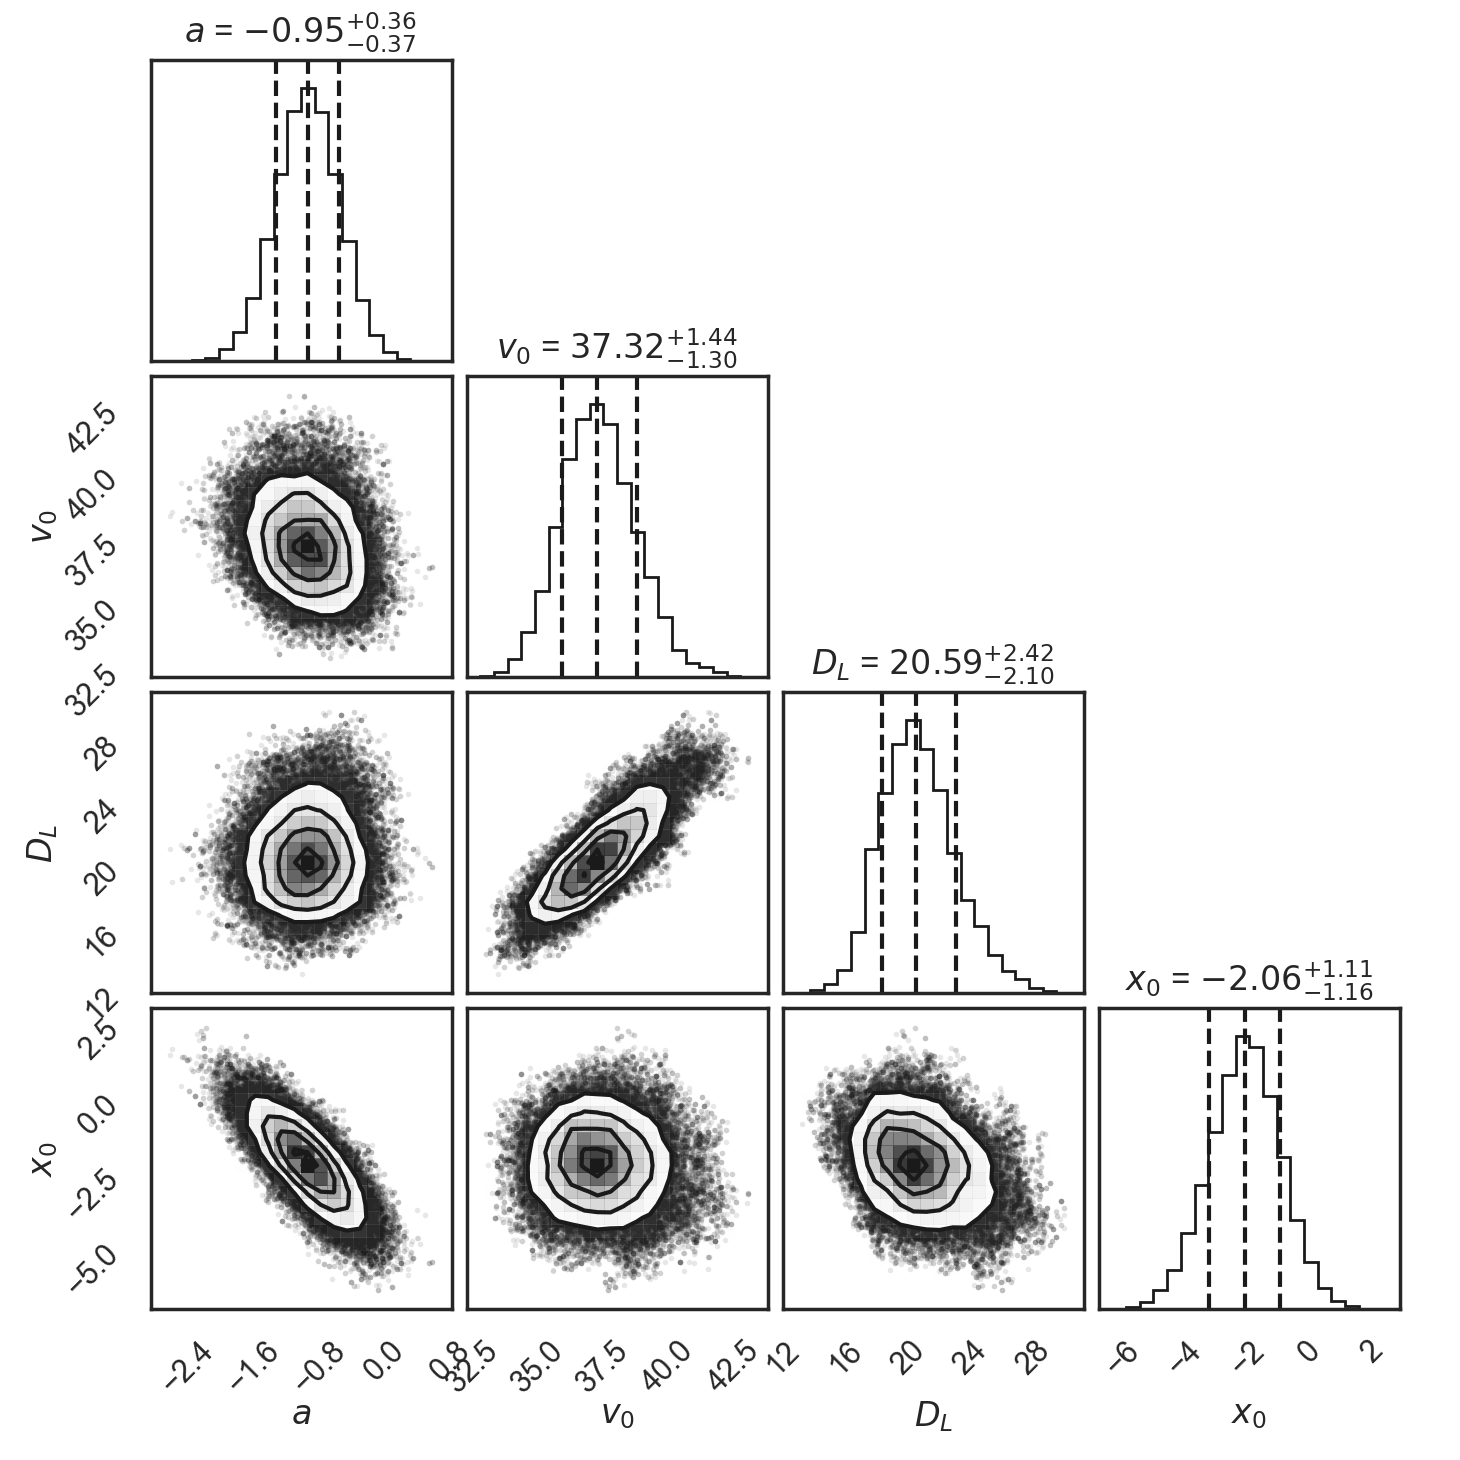

In [8]:
corer_plot = plt.figure(figsize=(7.3,7.3))
figure = corner.corner(np.array(samples[burn_in_index:]), labels=[r"$a$",r"$v_0$", r"$D_L$", r"$x_0$"],
                       quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12}, fig = corer_plot)

<IPython.core.display.Javascript object>


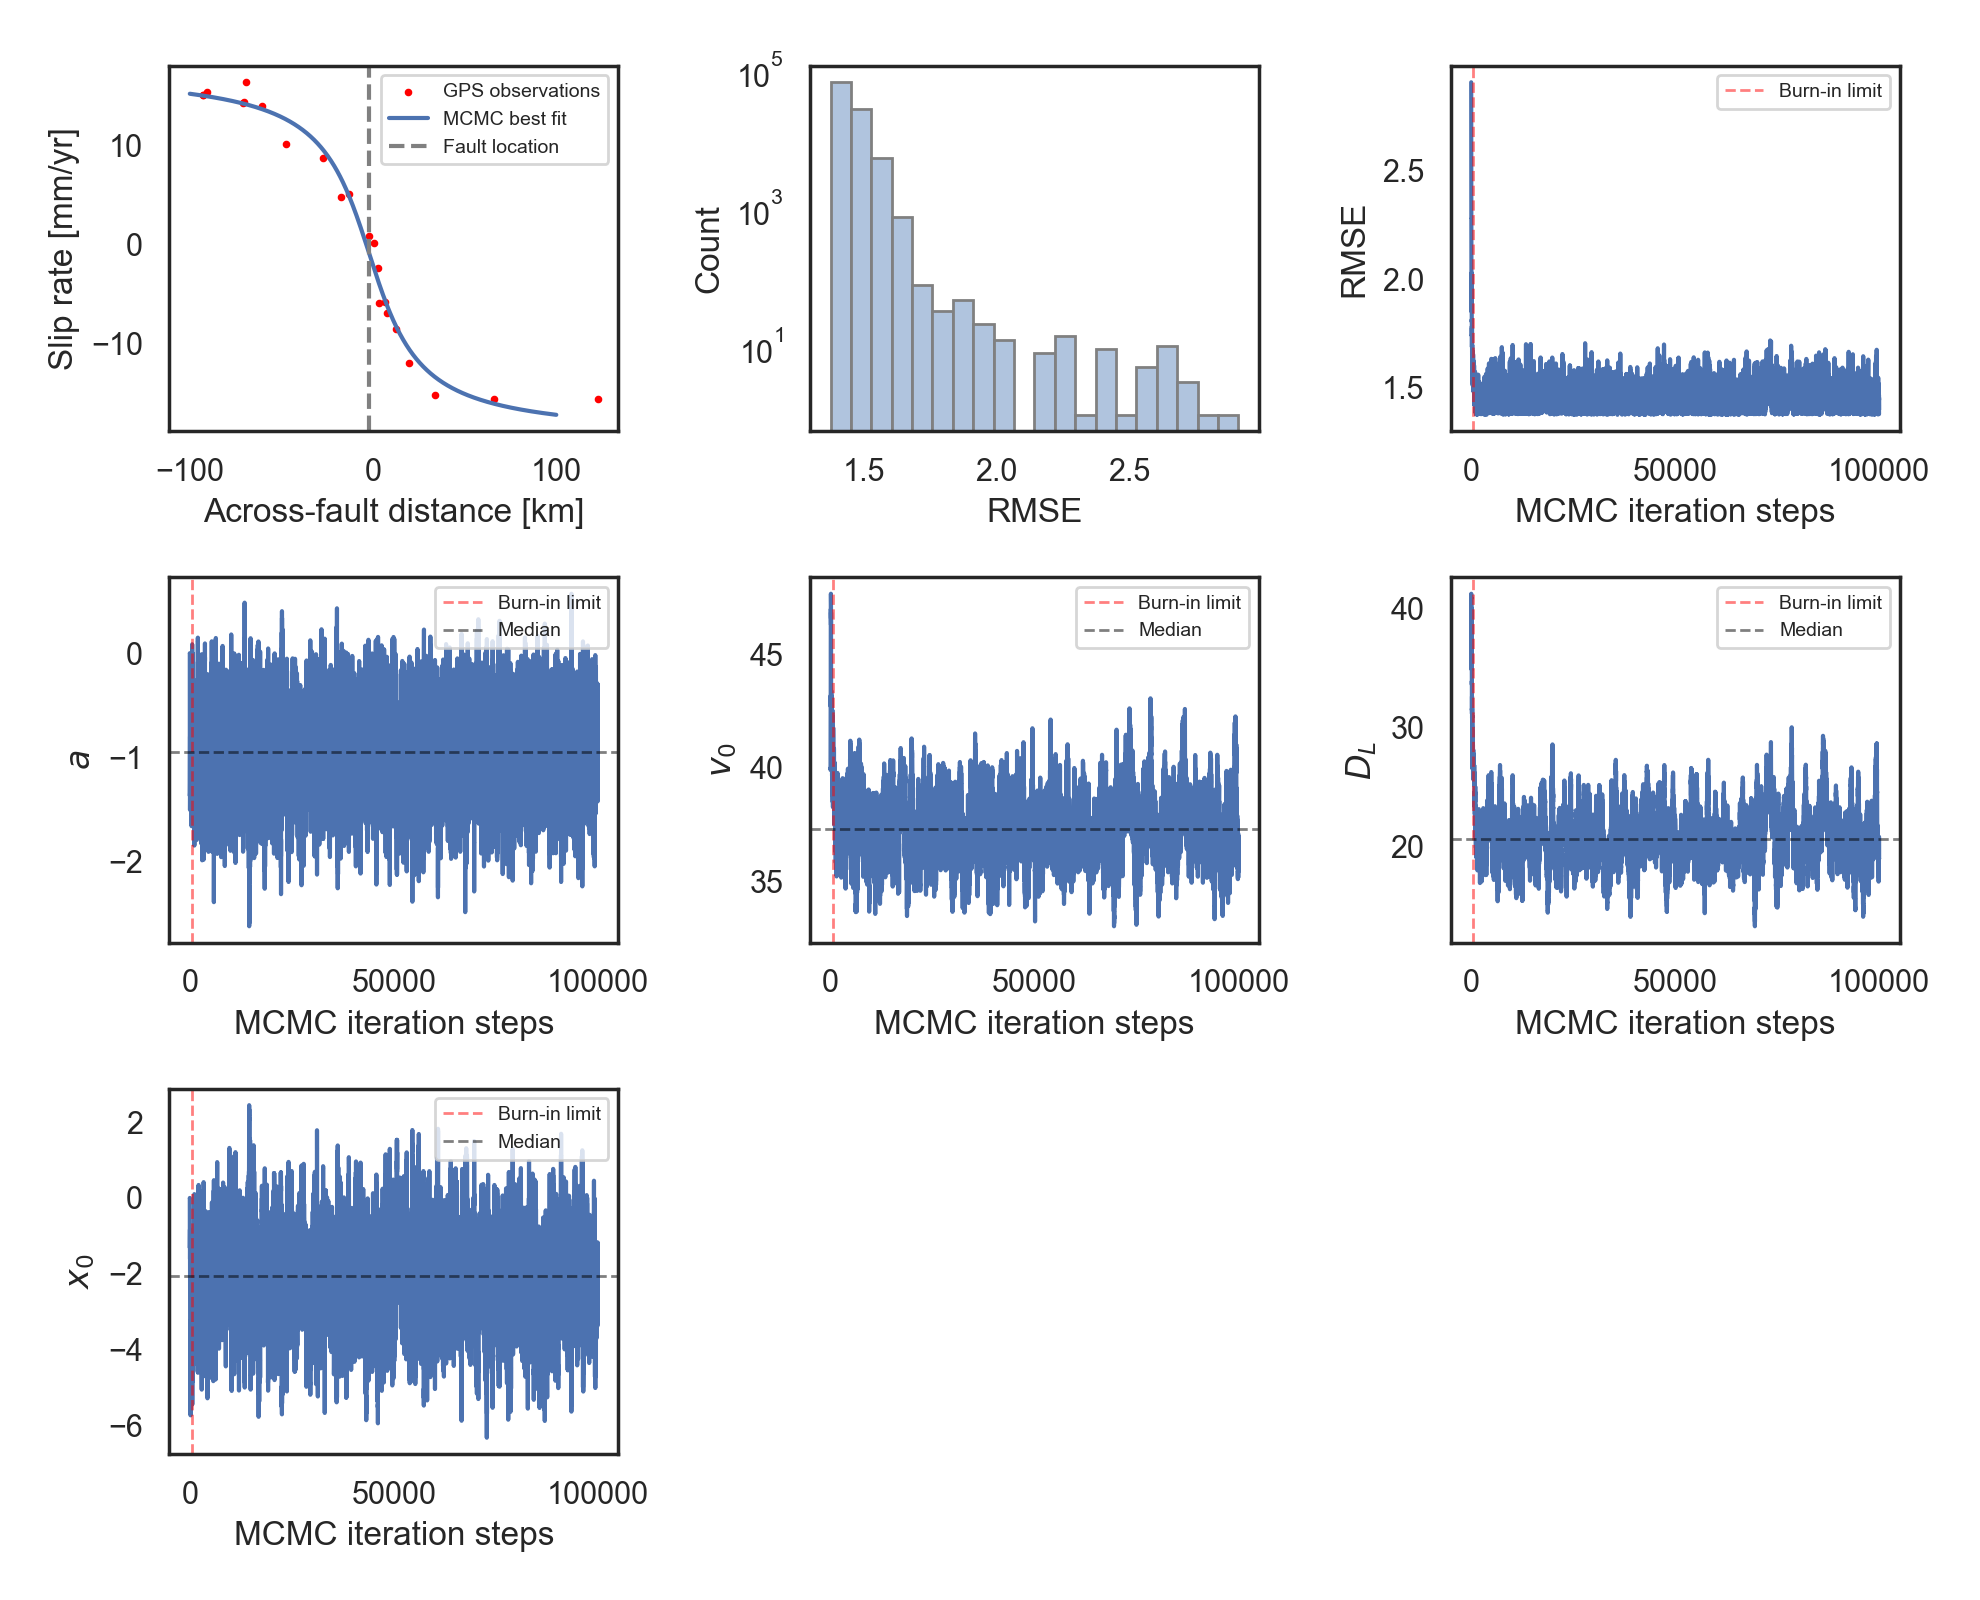

In [9]:
theta_no_burnin = np.median(samples[burn_in_index:], axis = 0) # Best fit model parameters

mult_fig = plt.figure(figsize=(9.9,8))
plt.subplot(3,3,1)
plt.scatter(x_data,v_data,s=3,color='red',label='GPS observations')
x = np.linspace(-100,100,1001)
plt.plot(x,model(theta_no_burnin,x),label='MCMC best fit')
plt.axvline(x=theta_no_burnin[3], linestyle='--',color='grey',label='Fault location')
plt.xlabel('Across-fault distance [km]')
plt.ylabel('Slip rate [mm/yr]')
plt.legend(loc=1, prop={'size': 7})

plt.subplot(3,3,2)
plt.hist(rmse_mcmc1,bins=20,color='lightsteelblue',ec='grey')
plt.yscale('log')
plt.xlabel('RMSE')
plt.ylabel('Count')

plt.subplot(3,3,3)
plt.plot(rmse_mcmc1)
plt.axvline(x=burn_in_index, linestyle='--',color='red',label='Burn-in limit', linewidth=1, alpha=0.5)
plt.legend(loc=1, prop={'size': 7})
plt.xlabel('MCMC iteration steps')
plt.ylabel('RMSE') 

plt.subplot(3,3,4)
plt.plot(samples[:,0])
plt.axvline(x=burn_in_index, linestyle='--',color='red',label='Burn-in limit', linewidth=1, alpha=0.5)
median_a = np.median(samples[burn_in_index:][:,0])
plt.axhline(y = median_a, color = 'black', linestyle = '--', label='Median', linewidth=1, alpha=0.5)
plt.legend(loc=1, prop={'size': 7})
plt.xlabel('MCMC iteration steps')
plt.ylabel('$a$') 

plt.subplot(3,3,5)
plt.plot(samples[:,1])
plt.axvline(x=burn_in_index, linestyle='--',color='red',label='Burn-in limit', linewidth=1, alpha=0.5)
median_v0 = np.median(samples[burn_in_index:][:,1])
plt.axhline(y = median_v0, color = 'black', linestyle = '--', label='Median', linewidth=1, alpha=0.5)
plt.legend(loc=1, prop={'size': 7})
plt.xlabel('MCMC iteration steps')
plt.ylabel('$v_0$') 

plt.subplot(3,3,6)
plt.plot(samples[:,2])
plt.axvline(x=burn_in_index, linestyle='--',color='red',label='Burn-in limit', linewidth=1, alpha=0.5)
median_d = np.median(samples[burn_in_index:][:,2])
plt.axhline(y = median_d, color = 'black', linestyle = '--', label='Median', linewidth=1, alpha=0.5)
plt.legend(loc=1, prop={'size': 7})
plt.xlabel('MCMC iteration steps')
plt.ylabel('$D_L$') 

plt.subplot(3,3,7)
plt.plot(samples[:,3])
plt.axvline(x=burn_in_index, linestyle='--',color='red',label='Burn-in limit', linewidth=1, alpha=0.5)
median_x0 = np.median(samples[burn_in_index:][:,3])
plt.axhline(y = median_x0, color = 'black', linestyle = '--', label='Median', linewidth=1, alpha=0.5)
plt.legend(loc=1, prop={'size': 7})
plt.xlabel('MCMC iteration steps')
plt.ylabel('$x_0$') 

mult_fig.tight_layout(pad=1.5)
plt.show()

## Part 3: Testing 
### Grid Search 

In [10]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%  Variables  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
pred = 0   # Declare variable pred (predicted velocity)  
diff = 0   # Declare variable dif (obsserved-predicted) ;
loc=0;     # Declare counter variable to be used when saving grid-search results
rmse=0;    # Declare variable rmse  

#%%%%%%%%%%%%%%%%%%%%%%%% Define Parameter Domain %%%%%%%%%%%%%%%%%%%%%%%%%%
ai=-2.0    # Minimum arctan shift considered
af=2.0     # Maximum arctan shift considered
vi=0.0     # Minimum slip rate considered
vf=80      # Maximum slip rate considered
di=0.1     # Minimum locking depth considered
df=80      # Maximum locking depth considered
x0i=-2.5   # Minimum fault location considered
x0f=2.5    # Maximum fault location considered
stepv=0.5  # Grid search step for slip rate in mm/yr
stepd=0.5  # Grid search step for locking depth in km
stepa=0.5  # Grid search step for arctan shift in mm/yr
stepx0=0.5 # Grid search step for fault location in km

#%%%%%%%%%%%%%%%%%% Initialise table containing the results %%%%%%%%%%%%%%%%
a_vals = np.arange(ai, af + stepa, stepa, dtype = float)
v_vals = np.arange(vi, vf + stepv, stepv, dtype = float)
d_vals = np.arange(di, df + stepd, stepd, dtype = float)
x0_vals = np.arange(x0i, x0f, stepx0, dtype = float)
numiter = len(a_vals) * len(v_vals) * len(d_vals) * len(x0_vals);
table = np.zeros((numiter,5), dtype = float) # Results array, 5 columns (# params)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [11]:
# Using meshgrid to avoid 4 nested for-loops to generate all the possible model-parameter combinations
table = np.array(np.meshgrid(a_vals, v_vals, d_vals, x0_vals, np.nan)).T.reshape(-1, 5)
a = table[:,0]  # parameter 1: Vertical shift of the arctan curve
v = table[:,1]  # parameter 2: Fault slip rate (amplitude of the arctan curve)
d = table[:,2]  # parameter 3: Fault locking depth (determines near-fault velocity gradient)
x0 = table[:,3] # parameter 4: 
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%  Functions  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def rms(x):
    return np.sqrt(x.dot(x)/x.size)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [12]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%% Grid Search Routine %%%%%%%%%%%%%%%%%%%%%%%%%%%
start_time = time.time()
for theta in range(len(table)):
    pred = elastic_model(x_data, a[theta], v[theta], d[theta], x0[theta])
    diff = (v_data-pred) 
    rmse = rms(diff) 
    table[loc,4]= rmse # Save RMSE for each model 
    loc=loc+1;         # Counter (index) to save all the results in the matrix
executionTime = (time.time() - start_time)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [13]:
#%%%%%%%%%%%%%%%%%%%%%%%%% Extract best fit model %%%%%%%%%%%%%%%%%%%%%%%%%%
best_rms = np.min(table[:,4]) # Get minimum rmse
index_best_rms = np.where(table[:,4] == np.min(table[:,4])) # Get minimum rmse index
results = table[index_best_rms,:] # Get model parameters with the lowest rmse
results = results.flatten()
best_a = results[0]  # Best fit arctangent vertical shift (a)
best_v = results[1]  # Best fit fault slip rate (v)
best_d = results[2]  # Best fit fault locking depth (d)
best_x0 = results[3] # Best fit fault locking depth (d)
print("Best fit model parameters [a, v_0, D_L, x_0] =", results[0:4])
print("Grid Search Execution Time (seconds):", executionTime)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Best fit model parameters [a, v_0, D_L, x_0] = [-1.  37.  20.1 -2. ]
Grid Search Execution Time (seconds): 20.36857581138611


<IPython.core.display.Javascript object>


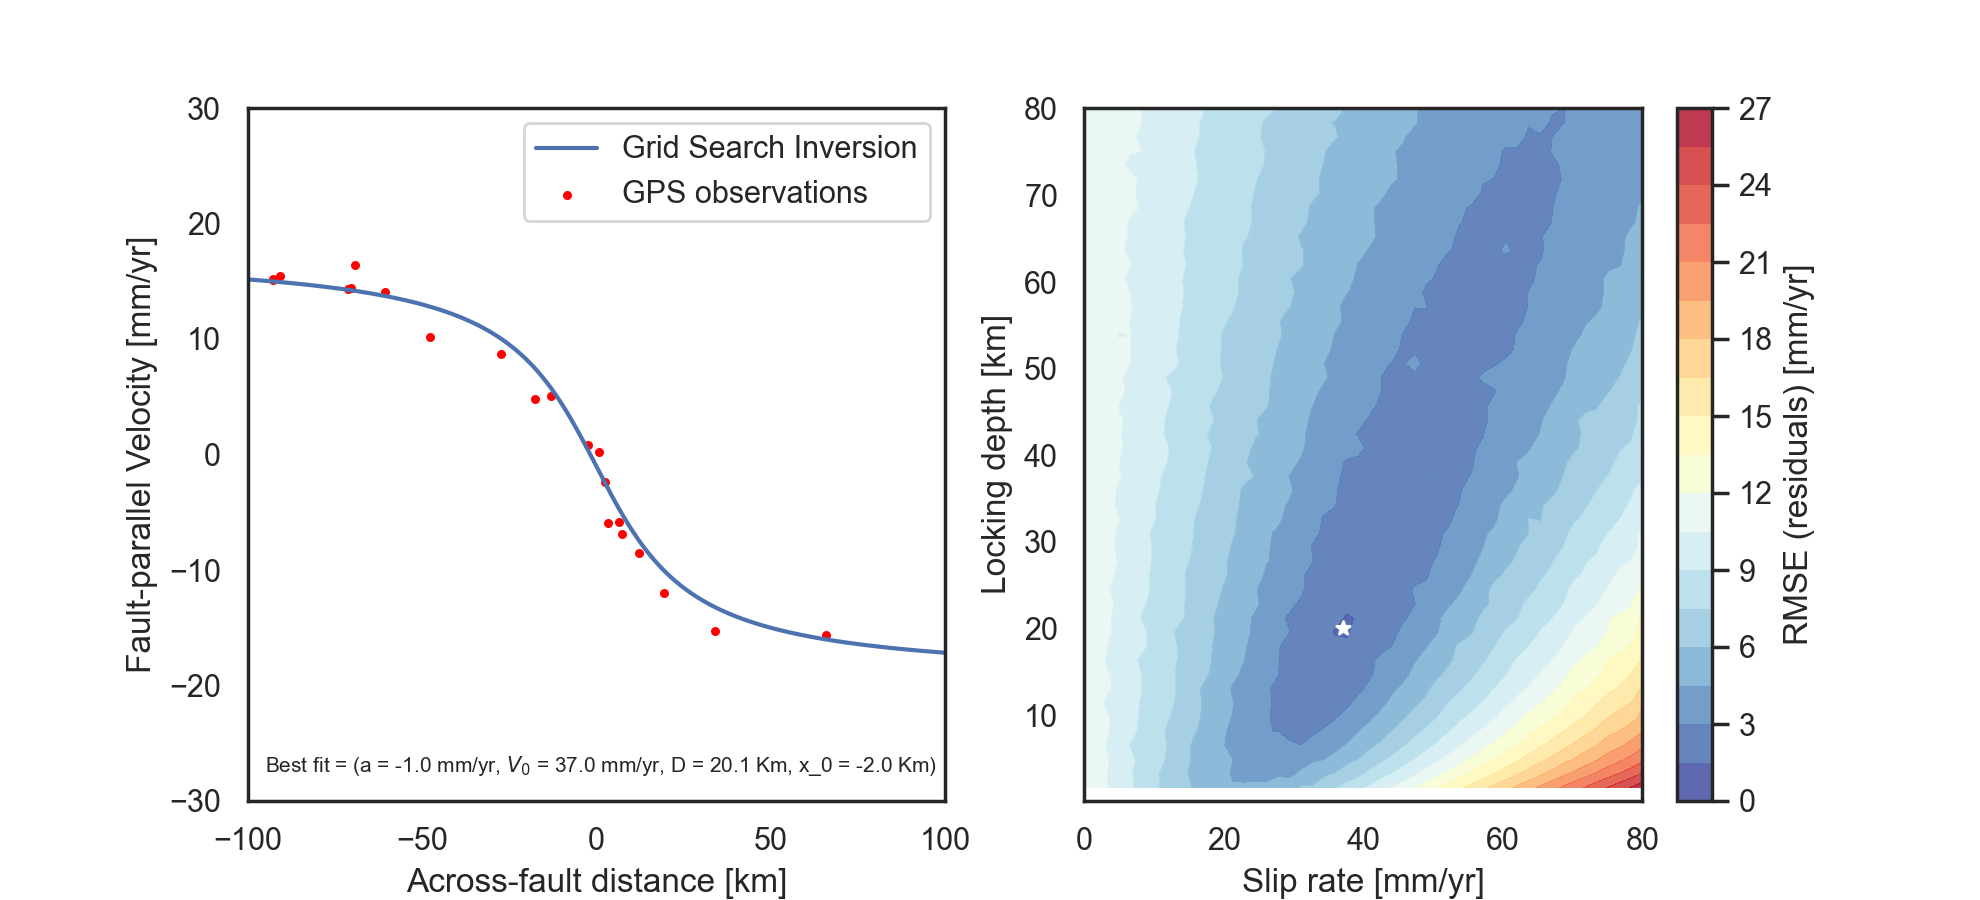

In [14]:
#%%%%%%%%%%%%%%%%%%%%%%%%%  Plotting parameters  %%%%%%%%%%%%%%%%%%%%%%%%%%%%
min_y = -30 # mm/yr
max_y = 30 # mm/yr

fig = plt.figure(figsize=(9.9,4.5))
ax1 = fig.add_subplot(1, 2, 1)
grid_search_model_predictions = elastic_model(x, best_a, best_v, best_d, 0)
ax1.plot(x, grid_search_model_predictions, label='Grid Search Inversion')
plt.scatter(x_data, v_data, s=5, color='red', label='GPS observations')
plt.xlabel('Across-fault distance [km]')
plt.ylabel('Fault-parallel Velocity [mm/yr]')
plt.legend()
offset = 5 
ax1.set(xlim=(min(x), max(x)), ylim=(min_y, max_y)) ;
disp = ax1.annotate('Best fit = (a = %.1f mm/yr, $V_0$ = %.1f mm/yr, D = %.1f Km, x_0 = %.1f Km)'%
                    (best_a, best_v, best_d, best_x0), (best_v, best_d), 
                    xytext = (min(x) + offset, min_y + 0.5*offset), fontsize=7.5)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%% Define Colormap  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%
RdYlBu_r = cm.get_cmap('RdYlBu_r', 256)
newcolors = RdYlBu_r(np.linspace(0, 1, 100))
newcmp = ListedColormap(newcolors)

#%%%%%%%%%  Interpolate RMSE values into a 50x50 grid and plot %%%%%%%%%%%%%
v_vals=table[:,1]
d_vals=table[:,2]
rmse_vals=table[:,4]
xi=np.linspace(0.,80.,50)
yi=np.linspace(0.,80.,50)

X,Y= np.meshgrid(xi,yi)
Z = griddata((v_vals, d_vals), rmse_vals, (X, Y),method='linear')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set(xlim=(min(v_vals), max(v_vals)), ylim=(min(d_vals), max(d_vals))) 
cs = plt.contourf(X,Y,Z,16,cmap=newcmp,alpha=0.8)
cbar = plt.colorbar(cs)
cbar.set_label('RMSE (residuals) [mm/yr]')
ax2.scatter(best_v, best_d, s=25, marker='*', color='white', zorder=2)
ax2.set_xlabel('Slip rate [mm/yr]')
ax2.set_ylabel('Locking depth [km]') ;